##  Optimze and a Dense Neural Network for gap filling and feature identification

** With a few tweaks to RepRunner, an LSTM can be run instead

In [15]:
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations
# from functools import partial
from multiprocessing import Pool
from functools import partial
from sklearn import metrics
# from sklearn.model_selection import train_test_split

## Personal Modules
import ReadStandardTimeFill as RSTF
import importlib
import DenseNet as Dense
import MiscFuncs as MF
importlib.reload(Dense)
importlib.reload(RSTF)
importlib.reload(MF)

# %matplotlib inline

%matplotlib notebook
%config IPCompleter.greedy=True

from scipy.optimize import minimize, curve_fit
from scipy.stats import norm
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, WhiteKernel, ConstantKernel
from sklearn.externals import joblib
from matplotlib import cm

from scipy import stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multicomp import MultiComparison

from ipywidgets import FloatProgress
from IPython.display import display
import os  
import shutil
from keras import backend as K
try:pool.close()
except:pass


def Test(params,X,y,YScaled,XScaled,pool):
    return(np.random.rand(params['K']))


def ModSelect(Scope,Site):
    if Site == 'Illisarvik':
        if Scope == 'Full':
            Model = ['H','wind_speed','air_pressure','PPFD_Avg','AirTC_Avg','VPD',
                    'Temp','VWC','Sedge','Shrub','Grass','Sparse','Out_of_Basin']
        if Scope == 'Test':
            Model = ['PPFD_Avg','VWC','wind_speed','Sedge']
    if Site == 'FishIsland':
        BaseFactors = []
        if Scope == 'Full':
            Model = ['H','Wind Spd','air pressure','Ta','Rn','PPFD','Rain','Water Table',
            'Ts 2.5 cm','Ts 15 cm','VWC','Active Layer','24H Rain','Wtr Tbl Trnd']
        if Scope == 'Test':
            Model = ['H','Water Table','Wind Spd','Active Layer']
    return(Model)

def Combos(Model,L,factor=None):
    Models=[]
    for c in combinations(Model,L):
        c = list(c)
        if factor is None:
            Models.append(c)
        else:
            for f in factor:
                f = f.split('+')
                if set(f).issubset(set(c)) and c not in Models:
                    Models.append(c)
                    
    print('Models: ',Models)
    return(Models)

def Stats(mse,j,i,params):
    df = pd.DataFrame(index = [str(j)+'_'+str(i)],
                      data={'Model':[params['Model']],
                            'MSE':[mse.mean()],
                            'SE':[mse.std()/params['K']**.5],
                            'Performance':0})
    return(df)

def t(p,n):
    alpha = 1-p
    df = n-1
    return(stats.t.ppf(alpha,df))


# FirstRun = True
# FirstRun = False

# MP=True
Scope = 'Full'
cwd = os.getcwd()
# for Site in ['Illisarvik','FishIsland']:
Site='Illisarvik'
target='fch4'
T= 1#t(0.05,params['K'])

# Model

In [51]:

params = Dense.Params(Scope,target,MP)
params['Dpath'] = cwd+'/'+Site+'/'
RST = RSTF.ReadStandardTimeFill(params,'ECData.csv')#,resample='2H')
params = Dense.Params(Scope,target,MP)
params['Dpath'] = cwd+'/'+Site+'/'
Records = pd.read_csv(params['Dpath']+'/'+target+'_Runs.csv',delimiter = ',',header = 0)

Min = Records.loc[Records['MSE']==Records['MSE'].min()]
Records.loc[Records['MSE']<=Min['MSE'].values[0]+Min['SE'].values[0]*T,'Performance']=2
Records.loc[Records['MSE']==Min['MSE'].values[0],'Performance']=3
T= 1#t(0.05,params['K'])
Honorable = Records.loc[Records['Performance']==1]
Top = Records.loc[Records['Performance']==2]
Best = Records.loc[Records['Performance']==3]



plt.figure()
plt.bar(Honorable.index,Honorable['MSE'],yerr=Honorable['SE'],color='blue')
plt.bar(Top.index,Top['MSE'],yerr=Top['SE'],color='green')
plt.bar(Best.index,Best['MSE'],yerr=Best['SE'],color='red')
Records.to_csv(params['Dpath']+'/'+target+'_Runs.csv')

ValueError: Can only compare identically-labeled Series objects

# Map Results

In [43]:
alt_mod=[True,'Sedge']
BestMod = Best['Model'].values[0]
Project = True
Fill = False
if alt_mod[0] == True:
    Model = alt_mod[1]
else:
    Model = BestMod
idx = Records['index'].loc[Records['Model']==Model].values[0]
Model = Model.split('+')
params['Spath']=(params['Dpath']+'/'+target+'/'+idx+'/')
params['Inputs']=Model
params['K']=2
RST.Scale(params['target'],params['Inputs'],ScalePath=params['Spath'])

Key = 'Sedge'
KeyRange = {'min':0,'max':1}

# Predict

In [44]:
if Project == True:
    for ip in params['Inputs']:
        RST.Data[ip] = RST.Data[ip].mean()
    RST.Data[Key] = np.linspace(KeyRange['min'],KeyRange['max'],RST.Data[Key].shape[0])
    RST.Data[Key] = RST.Data[Key].max()
    RST.Scale(params['target'],params['Inputs'],ScalePath=params['Spath'],Project=Project)
if __name__ == '__main__':
    if Fill == True:
        X = RST.X_fill
    else:
        X = RST.X
    params['Sname']='Y_'
    Y_fill = []
    MSE = []
    if MP == False:
        for k in range(params['K']):
            Y = Dense.Load_Model(k,X,params)
            Y = RST.YScaled.inverse_transform(Y)
            if Fill == False:
                mse = (metrics.mean_squared_error(RST.y,Y))
                MSE.append(mse)
            Y_fill.append(Y)
    else:
        pool = Pool(processes=1,maxtasksperchild=75)
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=params),range(params['K']))):
            Y = results
            Yold = Y+0
            Y = RST.YScaled.inverse_transform(Y)
            if Fill == False:
                mse = (metrics.mean_squared_error(RST.y,Y))
                MSE.append(mse)
            Y_fill.append(Y)                       
        pool.close()
    Y_fill = np.asanyarray(Y_fill).mean(axis=-1)
    Y_fill_bar = Y_fill.mean(axis=0)
    if Fill == False:
        MSE = np.asanyarray(MSE)
        CI = stats.t.ppf(1-0.025,k)*MSE.std()/(k)**.5
        print(CI)

    YStandard = joblib.load(params['Spath']+"YVar_scaler.save") 
    params['Sname']='Var'
    params['Loss']='Boot_Loss'
    if MP == False:
        for k in range(1,2):
            YVar = Dense.Load_Model(k,X,params)
            YVar = RST.YScaled.inverse_transform(YVar)
    else:
        pool = Pool(processes=1,maxtasksperchild=75)
        for k,results in enumerate(pool.imap(partial(Dense.Load_Model,X=X,params=params),range(1,2))):
            YVar = results
            YVar = RST.YScaled.inverse_transform(YVar)                    
        pool.close()
    X_back = np.squeeze(RST.XScaled.inverse_transform(X))


Data = pd.DataFrame(data=X_back,columns=params['Inputs'])
Data[target] = np.squeeze(Y_fill_bar)
Data['True'] = RST.Ytru#.YScaled.inverse_transform(RST.y)
Data['SE'] = 1/(params['K']-1)*((Y_fill-Y_fill_bar)**2).sum(axis=0)
Data['Var'] = np.squeeze(YVar)
Data['CI']=stats.t.ppf(1-0.025,params['K'])*(Data['SE'])**.5
Data['PI']=stats.t.ppf(1-0.025,params['K'])*((Data['Var']+Data['SE'])**.5) #the accuracy of our estimate with respect to the observed output

# print(Data['CI'].mean())
print(params['Inputs'])
print('Prediction mean: ',Data[target].mean())
print('Target mean: ',Data['True'].mean())
Data['Fill'] = Data['True'].fillna(Data[target])
print('GapFilled mean: ',Data['Fill'].mean())

Data.loc[np.isnan(Data['PI'])==True,'PI']=Data['CI']


0.35934895077590545
['Sedge']
Prediction mean:  0.9408426284790039
Target mean:  0.7434639075695412
GapFilled mean:  0.7434639075695412


<IPython.core.display.Javascript object>


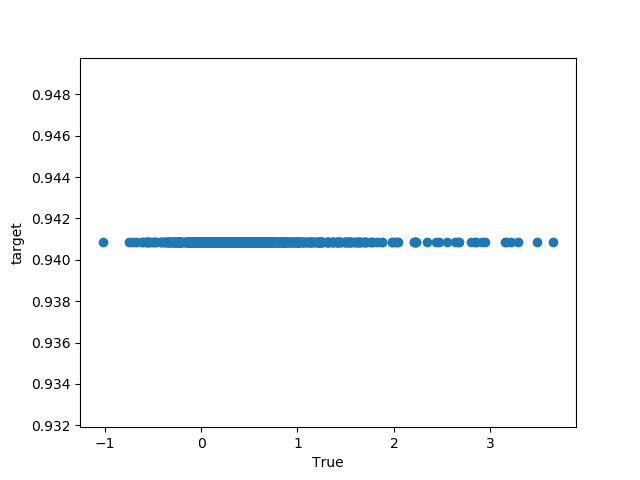

Text(0,0.5,'target')

In [45]:
plt.figure()
plt.scatter(RST.y,Y_fill_bar)
plt.xlabel('True')
plt.ylabel('target')

<IPython.core.display.Javascript object>


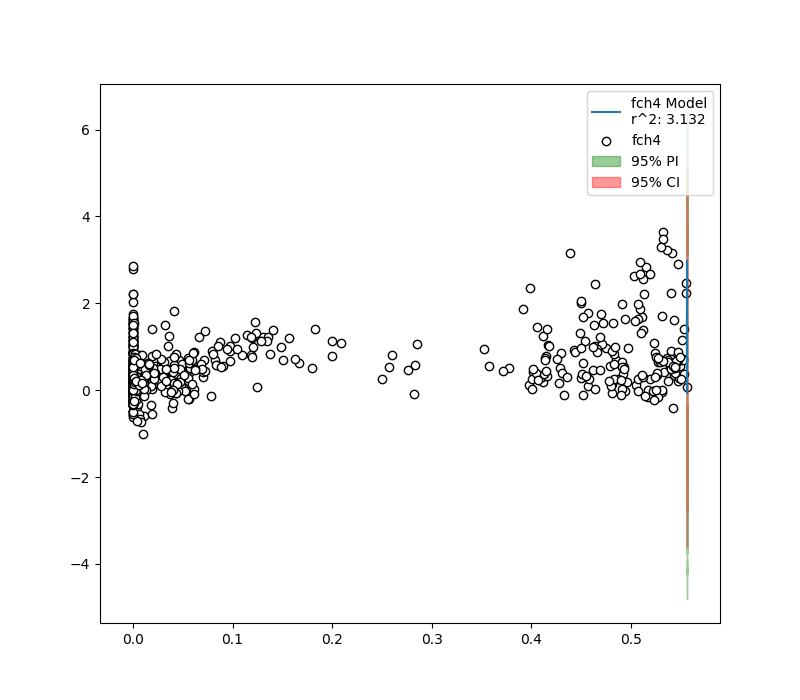

<IPython.core.display.Javascript object>


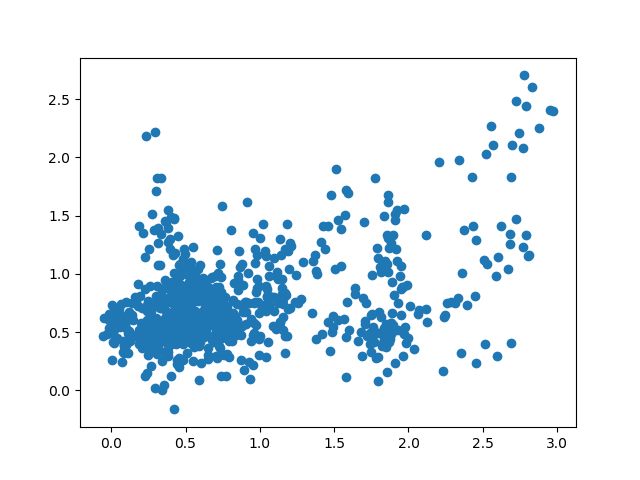

In [42]:

plt.figure(figsize=(8,7))
Data = Data.sort_values(by=Key)
# Data.index = Data[Key]

Data = Data[np.isfinite(Data['True'])]

plt.scatter(RST.Master[Key],RST.Master[target],edgecolor='black',facecolor='white')
plt.plot(Data[Key],Data[target],
         label= params['target']+' Model\nr^2: '+str(np.round(metrics.r2_score(Data['True'],
                                                                   Data[params['target']])**2,3)))
                                   
plt.fill_between(Data[Key], Data[target]-Data['PI'], 
                 Data[target]+Data['PI'],  color = 'green', alpha = 0.4, 
                 label = '95% PI')
plt.fill_between(Data[Key], Data[target]-Data['CI'], 
                 Data[target]+Data['CI'],  color = 'red', alpha = 0.4, 
                 label = '95% CI')
plt.legend()
# print(RST.Master)

plt.figure()

# plt.plot(Data[Key], Data['Var'])

plt.scatter(Data[target],Data['True'])

# print(Data['SE'])